# Notebook for estimating the electron lifetime
Track selection:
- Number of tracks in the event == 1
- Number of hits in the event > 50
- Track length > 250 mm
- Track length in z direction (drift) > 150 mm

For this selection, extract the charge deposition as a function of the drift distance and fit an exponential.

From the argument of the exponential, extract the electron lifetime.

### Imports

In [1]:
#import argparse
#from array import array
import glob
import math
import numpy as np
import os
import ROOT
from ROOT import TCanvas, TFile, TProfile, TNtuple, TH1F, TH2F, TH3F, TH1, TLine
#from ROOT import gROOT, gBenchmark, gRandom, gSystem, Double, gStyle
import scipy
import sys
import time

from plot_functions import *

Welcome to JupyROOT 6.22/02
Done.


### ROOT Batch Mode

In [2]:
# ROOT.gROOT.SetBatch(1)

### Paths

In [3]:
# ============================================================
# Set paths
# ============================================================
#!ls /data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/without_light/0_320_mm_drift/
#!ls /data/SingleModule_Nov2020/LArPix/dataRuns/convertedData/

datapath = '/data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light'
print(' datapath:   ', datapath)

outputpath = '/home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation'
print(' outputpath: ', outputpath)

files = sorted([os.path.basename(path) for path in glob.glob(datapath+'/*.root')])
print(' datafiles (', len(files), '): ')
for f in files:
    print('              ', f)

 datapath:    /data/SingleModule_Nov2020/LArPix/dataRuns/rootTrees/combined_with_light
 outputpath:  /home/lhep/PACMAN/larpix-analysis/lightCharge_anticorrelation
 datafiles ( 22 ): 
               sync_wLightReco_20201129_122204.root
               sync_wLightReco_20201129_122655.root
               sync_wLightReco_20201129_130449.root
               sync_wLightReco_20201129_134857.root
               sync_wLightReco_20201129_143427.root
               sync_wLightReco_20201129_150749.root
               sync_wLightReco_20201129_155227.root
               sync_wLightReco_20201129_162434.root
               sync_wLightReco_20201129_170918.root
               sync_wLightReco_20201129_174140.root
               sync_wLightReco_20201129_182214.root
               sync_wLightReco_20201129_185437.root
               sync_wLightReco_20201129_193550.root
               sync_wLightReco_20201129_200721.root
               sync_wLightReco_20201129_204607.root
               sync_wLightReco_202011

### Define voxelisation

In [4]:
# ============================================================
# Define voxelisation
# ============================================================
n_pixels_x = 70
n_pixels_y = 70
n_pixels_z = 70
pitch_x = 4.434
pitch_y = 4.434
pitch_z = 4.434
pixels_x_min = - pitch_x * n_pixels_x/2. #155.19
pixels_x_max =   pitch_x * n_pixels_x/2. #155.19
pixels_y_min = - pitch_y * n_pixels_y/2. #155.19
pixels_y_max =   pitch_y * n_pixels_y/2. #155.19
pixels_z_min = 0
pixels_z_max = n_pixels_z*pitch_z #*10 # factor 10 for correction... TODO: CHANGE THIS FOR NEXT PRODUCTION!! # TODO: WHAT IS THE MAX DRIFT LENGTH?
print(pixels_z_max)
#pixels_z_min = - pitch_z * n_pixels_z/2. #155.19
#pixels_z_max =   pitch_z * n_pixels_z/2. #155.19
#pixels_y_min = -155.19
#pixels_y_max = 155.19

310.38


### Make List of TChains
Note: Make for every file a separate TChain.
TChain would simplify the combination of >1 files (e.g. if you have several short runs)

In [5]:
#inputFileName = files[20]
#inputFileName = 'sync_wLightReco_20201129_122204.root'
#print(' Processing file', inputFileName)

input_tree_list       = []
eField_intensity_list = [] # [kV/cm]


for i in range(len(files)):
    input_tree = ROOT.TChain("t_out", "t_out")
    #print(' files[',i,']: ', files[i])
    
    if files[i] == 'sync_wLightReco_20201130_002722.root' or\
       files[i] == 'sync_wLightReco_20201130_005847.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.1)
    if files[i] == 'sync_wLightReco_20201129_230700.root' or\
       files[i] == 'sync_wLightReco_20201129_234000.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.2)
    if files[i] == 'sync_wLightReco_20201129_215550.root' or\
       files[i] == 'sync_wLightReco_20201129_222751.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.3)
    if files[i] == 'sync_wLightReco_20201129_204607.root' or\
       files[i] == 'sync_wLightReco_20201129_211819.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.4)
    if files[i] == 'sync_wLightReco_20201129_193550.root' or\
       files[i] == 'sync_wLightReco_20201129_200721.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.5)
    if files[i] == 'sync_wLightReco_20201129_182214.root' or\
       files[i] == 'sync_wLightReco_20201129_185437.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.6)
    if files[i] == 'sync_wLightReco_20201129_170918.root' or\
       files[i] == 'sync_wLightReco_20201129_174140.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.7)
    if files[i] == 'sync_wLightReco_20201129_155227.root' or\
       files[i] == 'sync_wLightReco_20201129_162434.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.8)
    if files[i] == 'sync_wLightReco_20201129_143427.root' or\
       files[i] == 'sync_wLightReco_20201129_150749.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(0.9)
    if files[i] == 'sync_wLightReco_20201129_122204.root' or\
       files[i] == 'sync_wLightReco_20201129_122655.root' or\
       files[i] == 'sync_wLightReco_20201129_130449.root' or\
       files[i] == 'sync_wLightReco_20201129_134857.root':
        input_tree.Add(datapath + '/' + files[i])
        eField_intensity_list.append(1.0)
    
    # Turn on all branches of input tree
    input_tree.SetBranchStatus("*",           1)
    
    # Append input_tree TChain to the input_tree_list
    input_tree_list.append(input_tree)
    
n_field_intensities = len(np.unique(eField_intensity_list))
print('Number of different field intensities: ', n_field_intensities)
    
print('List with input trees: ')
for i in range(len(input_tree_list)):
    print('   ', eField_intensity_list[i], 'kV/cm: \t [', input_tree_list[i], '] \t (', input_tree_list[i].GetEntries(), 'entries )')
    
print('Done.')

Number of different field intensities:  10
List with input trees: 
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 1807 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19770 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19234 entries )
    1.0 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19520 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19657 entries )
    0.9 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19369 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19261 entries )
    0.8 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18800 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 19185 entries )
    0.7 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18178 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18720 entries )
    0.6 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18202 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18086 entries )
    0.5 kV/cm: 	 [ Name: t_out Title: t_out ] 	 ( 18149 entries )
    0.4 kV

### Create directories for plots

In [6]:
'''
# If make_plots: Create corresponding folder
make_plots = True

if make_plots:
    plot_folder = inputFileName[16:-5]
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
'''
'''
for i in range(len(eField_intensity_list)):
    plot_folder = str(eField_intensity_list[i]) + '_kV_per_cm'
    os.system('rm -rf plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder))
    os.system('mkdir plots/' + str(plot_folder) + '/eventDisplays')
'''
os.system('rm -rf plots')
os.system('mkdir plots')
print('Done.')

Done.


### Define electron drift velocities for every TChain

In [7]:
# Make a list with electron lifetimes
eDrift_vel = [] # drift velocities [mm/us]

for chain in range(len(input_tree_list)):
    if   eField_intensity_list[chain] == 0.1: eDrift_vel.append(0.535)
    elif eField_intensity_list[chain] == 0.2: eDrift_vel.append(0.933)
    elif eField_intensity_list[chain] == 0.3: eDrift_vel.append(1.230)
    elif eField_intensity_list[chain] == 0.4: eDrift_vel.append(1.461)
    elif eField_intensity_list[chain] == 0.5: eDrift_vel.append(1.648)
    elif eField_intensity_list[chain] == 0.6: eDrift_vel.append(1.806)
    elif eField_intensity_list[chain] == 0.7: eDrift_vel.append(1.941)
    elif eField_intensity_list[chain] == 0.8: eDrift_vel.append(2.060)
    elif eField_intensity_list[chain] == 0.9: eDrift_vel.append(2.166)
    elif eField_intensity_list[chain] == 1.0: eDrift_vel.append(2.261)
    else:
        print(' WARNING: No eDrift velocity defined for eField intensity =', eField_intensity_list[chain], 'kV/cm ...')
        eDrift_vel.append(9999.9)
    
print('File summary: ')
for chain in range(len(input_tree_list)):
    print('    file', chain, ':\t', files[chain],\
          '\t E-field: ', eField_intensity_list[chain],\
          '\t eDrift: ', eDrift_vel[chain], 'mm/us')
    
print('Done.')

File summary: 
    file 0 :	 sync_wLightReco_20201129_122204.root 	 E-field:  1.0 	 eDrift:  2.261 mm/us
    file 1 :	 sync_wLightReco_20201129_122655.root 	 E-field:  1.0 	 eDrift:  2.261 mm/us
    file 2 :	 sync_wLightReco_20201129_130449.root 	 E-field:  1.0 	 eDrift:  2.261 mm/us
    file 3 :	 sync_wLightReco_20201129_134857.root 	 E-field:  1.0 	 eDrift:  2.261 mm/us
    file 4 :	 sync_wLightReco_20201129_143427.root 	 E-field:  0.9 	 eDrift:  2.166 mm/us
    file 5 :	 sync_wLightReco_20201129_150749.root 	 E-field:  0.9 	 eDrift:  2.166 mm/us
    file 6 :	 sync_wLightReco_20201129_155227.root 	 E-field:  0.8 	 eDrift:  2.06 mm/us
    file 7 :	 sync_wLightReco_20201129_162434.root 	 E-field:  0.8 	 eDrift:  2.06 mm/us
    file 8 :	 sync_wLightReco_20201129_170918.root 	 E-field:  0.7 	 eDrift:  1.941 mm/us
    file 9 :	 sync_wLightReco_20201129_174140.root 	 E-field:  0.7 	 eDrift:  1.941 mm/us
    file 10 :	 sync_wLightReco_20201129_182214.root 	 E-field:  0.6 	 eDrift:  1.806 mm

### Define track selection cuts

In [8]:
# Define Selection Cuts
cut_ntracks      = 1    # Only consider events with number of reconstructed tracks == cut_ntracks
cut_nhits        = 50.  # Min. number of hits in the track [-]
cut_lenght       = 250. # Track minimum length [mm]
cut_length_z     = 150. # Track minimum length in z direction (drift) [mm]

#cut_z_min_max    = [50. , 270.] # Track must start and end close to anode and cathode
#cut_start_z_min  = 50
#cut_start_z_max  = 270
#cut_residual2    = 3.   # Maximum allowed sqrt(res_x**2+res_y**2+res_z**2), in order to only allow tracks which are 'track-like' with a small spread

### Loop over all TChains in input_tree_list

In [9]:
# Progress bar
from IPython.display import HTML, display

def progress(count, total, unit, message=''):
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {count}/{total} {unit} ({frac}%) ... {message}
    """.format(count=count, total=total, unit=unit, frac=int(float(count)/float(total)*100.),message=message))

In [10]:
selected_trackIDs_list  = [] # list of n (=number of input files) lists containing the selected trackIDs
rejected_trackIDs_list  = [] # list of n (=number of input files) lists containing the rejected trackIDs
all_hits_x_list         = []
all_hits_y_list         = []
all_hits_z_list         = []
all_hits_q_list         = []

start = time.time()
out = display(progress(0,len(input_tree_list),'files processed'),display_id=True)
for chain in range(len(input_tree_list)):
    #print(input_tree_list[chain].Print())
    
    #if chain>1:
    #    break
    
    #if chain != 18:
    #    continue
    
    n_tracks = input_tree_list[chain].GetEntries()    
    
    print('     Chain Nr.', chain)
    print('         eField [kV/cm]:     ', eField_intensity_list[chain])
    print('         eDrift_vel [mm/us]: ', eDrift_vel[chain])
    print('         Number of tracks : ', n_tracks)

    selected_trackIDs  = []
    rejected_trackIDs  = []
    #track_length       = []
    #track_n_hits       = []
    #track_q_raw_tot    = []
    #track_start_pos_x  = []
    #track_start_pos_y  = []
    #track_start_pos_z  = []
    #track_end_pos_x    = []
    #track_end_pos_y    = []
    #track_end_pos_z    = []
    all_hits_x         = []
    all_hits_y         = []
    all_hits_z         = []
    all_hits_q         = []

    # Loop over all tracks in input_tree
    for track_id in range(n_tracks):
        input_tree_list[chain].GetEntry(track_id)
        
        if(track_id%10000==0 or track_id==n_tracks-1):
            now = time.time()
            print('             Processing', track_id, 'of', n_tracks, 'tracks. \t Elapsed time:', math.ceil(now-start), ' seconds ... \r')
        
        # Apply Selection Cuts
        if input_tree_list[chain].t_event_ntracks > cut_ntracks:
            rejected_trackIDs.append(track_id)
            continue
        if input_tree_list[chain].t_event_nhits < cut_nhits:
            rejected_trackIDs.append(track_id)
            continue
        if input_tree_list[chain].t_track_length < cut_lenght:
            rejected_trackIDs.append(track_id)
            continue
        if abs(input_tree_list[chain].t_track_start_pos_z-input_tree_list[chain].t_track_end_pos_z) < cut_length_z:
            rejected_trackIDs.append(track_id)
            continue
        '''
        if abs(input_tree_list[chain].t_track_end_pos_z-input_tree_list[chain].t_track_start_pos_z) < (cut_z_min_max[1]-cut_z_min_max[0]):
            rejected_trackIDs.append(track_id)
            continue
        if min(input_tree_list[chain].t_track_end_pos_z,input_tree_list[chain].t_track_start_pos_z)>cut_start_z_min or\
           max(input_tree_list[chain].t_track_end_pos_z,input_tree_list[chain].t_track_start_pos_z)<cut_start_z_max:
            rejected_trackIDs.append(track_id)
            continue
        if min(input_tree_list[chain].t_track_end_pos_z,input_tree_list[chain].t_track_start_pos_z)>cut_start_z_min:
            rejected_trackIDs.append(track_id)
            continue
        '''
        '''
        if input_tree_list[chain].t_track_start_pos_z > input_tree_list[chain].t_track_end_pos_z:
            if input_tree_list[chain].t_track_start_pos_z < cut_z_min_max[1] or input_tree_list[chain].t_track_end_pos_z > cut_z_min_max[0]:
                rejected_trackIDs.append(track_id)
                continue
        else:
            if input_tree_list[chain].t_track_end_pos_z < cut_z_min_max[1] or input_tree_list[chain].t_track_start_pos_z > cut_z_min_max[1]:
                rejected_trackIDs.append(track_id)
                continue
        '''
        
        #print(' passed! ') 
        selected_trackIDs.append(track_id)
        
        '''        
        print(' ----------------------------------------- ')
        #print(' t_eventID:           ', input_tree_list[chain].t_eventID)
        print(' t_trackID:           ', input_tree_list[chain].t_trackID)
        print(' t_track_length:      ', input_tree_list[chain].t_track_length)
        print(' t_event_ntracks:     ', input_tree_list[chain].t_event_ntracks)
        print(' track start:         ', input_tree_list[chain].t_track_start_pos_x,input_tree_list[chain].t_track_start_pos_y,input_tree_list[chain].t_track_start_pos_z)
        print(' track end:           ', input_tree_list[chain].t_track_end_pos_x,input_tree_list[chain].t_track_end_pos_y,input_tree_list[chain].t_track_end_pos_z)
        #print(' t_track_start_pos_y: ', input_tree_list[chain].t_track_start_pos_y)
        #print(' t_track_end_pos_y:   ', input_tree_list[chain].t_track_end_pos_y)
        print(' t_event_q:           ', input_tree_list[chain].t_event_q)
        print(' t_track_q:           ', input_tree_list[chain].t_track_q)
        print(' t_event_nhits:       ', input_tree_list[chain].t_event_nhits)
        print(' t_track_nhits:       ', input_tree_list[chain].t_track_nhits)
        #print(' t_tlcm1_tot:         ', input_tree_list[chain].l_tlcm1_tot)
        '''

        #track_length.append(input_tree_list[chain].t_track_length)
        #track_n_hits.append(input_tree_list[chain].t_track_nhits)
        #track_q_raw_tot.append(input_tree_list[chain].t_track_q)
        #track_start_pos_x.append(input_tree_list[chain].t_track_start_pos_x)
        #track_start_pos_y.append(input_tree_list[chain].t_track_start_pos_y)
        #track_start_pos_z.append(input_tree_list[chain].t_track_start_pos_z)
        #track_end_pos_x.append(input_tree_list[chain].t_track_end_pos_x)
        #track_end_pos_y.append(input_tree_list[chain].t_track_end_pos_y)
        #track_end_pos_z.append(input_tree_list[chain].t_track_end_pos_z)
        
        # Loop over all hits
        #q_raw_tot  = 0.
        for hit in range(input_tree_list[chain].t_track_nhits):
            hit_x =     input_tree_list[chain].t_track_hits_x[hit]
            hit_y =     input_tree_list[chain].t_track_hits_y[hit]
            hit_z = 0.1*input_tree_list[chain].t_track_hits_z[hit] # TODO: factor 0.1 due to factor 10 problem -> fix it
            hit_q = input_tree_list[chain].t_track_hits_q[hit]
            #q_raw_tot += hit_q
            all_hits_x.append(hit_x)
            all_hits_y.append(hit_y)
            all_hits_z.append(hit_z)
            all_hits_q.append(hit_q)

    all_hits_x_list.append(all_hits_x)
    all_hits_y_list.append(all_hits_y)
    all_hits_z_list.append(all_hits_z)
    all_hits_q_list.append(all_hits_q)
        
    selected_trackIDs_list.append(selected_trackIDs)
    rejected_trackIDs_list.append(rejected_trackIDs)

    out.update(progress(chain,len(input_tree_list),'files processed'))
out.update(progress(len(input_tree_list),len(input_tree_list),'files processed'))
print(' Done.')

     Chain Nr. 0
         eField [kV/cm]:      1.0
         eDrift_vel [mm/us]:  2.261
         Number of tracks :  1807
             Processing 0 of 1807 tracks. 	 Elapsed time: 1  seconds ... 
             Processing 1806 of 1807 tracks. 	 Elapsed time: 1  seconds ... 
     Chain Nr. 1
         eField [kV/cm]:      1.0
         eDrift_vel [mm/us]:  2.261
         Number of tracks :  19770
             Processing 0 of 19770 tracks. 	 Elapsed time: 1  seconds ... 
             Processing 10000 of 19770 tracks. 	 Elapsed time: 4  seconds ... 
             Processing 19769 of 19770 tracks. 	 Elapsed time: 7  seconds ... 
     Chain Nr. 2
         eField [kV/cm]:      1.0
         eDrift_vel [mm/us]:  2.261
         Number of tracks :  19234
             Processing 0 of 19234 tracks. 	 Elapsed time: 7  seconds ... 
             Processing 10000 of 19234 tracks. 	 Elapsed time: 10  seconds ... 
             Processing 19233 of 19234 tracks. 	 Elapsed time: 13  seconds ... 
     Chain Nr. 3

In [11]:
# Plot 3D event display of (the first N_hits_max) tracks
N_hits_max = 1000
out = display(progress(0,len(input_tree_list),'files processed'),display_id=True)
for chain in range(len(input_tree_list)):
    x_min    = pixels_x_min
    x_max    = pixels_x_max
    y_min    = pixels_y_min
    y_max    = pixels_y_max
    z_min    = 0
    z_max    = 320 #max(pixels_z_max,np.max(all_hits_z_list[chain]))
    n_bins_x = n_pixels_x
    n_bins_y = n_pixels_y
    n_bins_z = n_pixels_z
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    z_bins = np.linspace(z_min,z_max,n_bins_z)
    save_name = 'plots/h3_first_'+str(N_hits_max)+'_hits_'+str(files[chain][16:-5])+'.png'
    plot_event_3D([all_hits_x_list[chain][0:N_hits_max],all_hits_y_list[chain][0:N_hits_max],all_hits_z_list[chain][0:N_hits_max],all_hits_q_list[chain][0:N_hits_max]],\
                  x_bins,y_bins,z_bins,\
                  ['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]','Charge Deposition [ke]'],\
                  save_name)
    #print(' plot saved as', save_name)
    out.update(progress(chain,len(input_tree_list),'files processed'))
out.update(progress(len(input_tree_list),len(input_tree_list),'files processed'))
print('Done.')

/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


Done.


In [12]:
# Plot hits_q vs hits_z:
out = display(progress(0,len(input_tree_list),'files processed'),display_id=True)
for chain in range(len(input_tree_list)):
    x_min    = 0
    x_max    = 320 #max(pixels_z_max,np.max(all_hits_z_list[chain]))
    y_min    = 0
    y_max    = 500 #np.max(all_hits_q_list[chain])
    n_bins_x = 32
    n_bins_y = 50
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Coordinate z [mm]','Total Deposited Charge [ke]','Entries [-]']
    save_name = 'plots/h2_q_vs_z_'+str(files[chain][16:-5])+'.png'
    plot_h2([all_hits_z_list[chain],all_hits_q_list[chain]],x_bins,y_bins,axis_labels,save_name)
    #print(' plot saved as', save_name)
    out.update(progress(chain,len(input_tree_list),'files processed'))
out.update(progress(len(input_tree_list),len(input_tree_list),'files processed'))
print('Done.')

Done.


In [13]:
# Plot qPerHit vs hits_z:

pos_z_list  = []
mean_q_list = []
x_err_list  = []
sem_q_list  = []

out = display(progress(0,len(input_tree_list),'files processed'),display_id=True)
for chain in range(len(input_tree_list)):
    #if chain != 18:
    #    continue
    x_min    = 0
    x_max    = 320 #max(pixels_z_max,np.max(all_hits_z_list[chain]))
    y_min    = 80
    y_max    = 200 #np.max(all_hits_q_list[chain])
    n_bins_x = 10+1
    n_bins_y = 10
    x_bins = np.linspace(x_min,x_max,n_bins_x)
    y_bins = np.linspace(y_min,y_max,n_bins_y)
    axis_labels = ['Coordinate z [mm]','Deposited Charge per Hit [ke]','Entries [-]']
    
    '''
    mean_q = []
    z_pos  = []
    for ibin in range(n_bins_x-1):
        q_raw  = 0.
        n_hits = 0
        for ihit in range(len(all_hits_z_list[chain])):
            if all_hits_z_list[chain][ihit] > x_bins[ibin] and all_hits_z_list[chain][ihit] < x_bins[ibin+1]:
                q_raw  += all_hits_q_list[chain][ihit]
                n_hits += 1
        mean_q.append(np.nanmean(q_raw))
        z_pos.append(0.5*(x_bins[ibin]+x_bins[ibin+1]))
    print(mean_q)
    '''
    
    mean_q = []
    std_q  = []
    sem_q  = [] # standard error of the mean
    z_pos  = []
    x_err  = []
    for ibin in range(n_bins_x-1):
        q_raw  = []
        #n_hits = 0
        for ihit in range(len(all_hits_z_list[chain])):
            if all_hits_z_list[chain][ihit] > x_bins[ibin] and all_hits_z_list[chain][ihit] < x_bins[ibin+1]:
                q_raw.append(all_hits_q_list[chain][ihit])
                #n_hits += 1
        mean_q.append(np.nanmean(q_raw))
        std_q.append(np.nanstd(q_raw))
        sem_q.append(scipy.stats.sem(q_raw))
        z_pos.append(0.5*(x_bins[ibin]+x_bins[ibin+1]))
        x_err.append(0.5*(x_bins[1]-x_bins[0]))
    
    pos_z_list.append(z_pos)
    mean_q_list.append(mean_q)
    x_err_list.append(x_err)
    sem_q_list.append(sem_q)
    
    axis_labels = ['Coordinate z [mm]','Deposited Charge per Hit [ke]','Entries [-]']
    
    save_name = 'plots/TGraphError_qPerHit_vs_z_'+str(files[chain][16:-5])+'.png'
    plot_errorbars(z_pos,mean_q,x_err,sem_q,x_min,x_max,y_min,y_max,axis_labels,save_name)

    #print(' plot saved as', save_name)
    out.update(progress(chain,len(input_tree_list),'files processed'))
out.update(progress(len(input_tree_list),len(input_tree_list),'files processed'))
print('Done.')

<ipython-input-13-418ede23e30a>:49: RuntimeWarning: Mean of empty slice
  mean_q.append(np.nanmean(q_raw))
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/roman/software/anaconda3/envs/larpix-analysis-38/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Done.


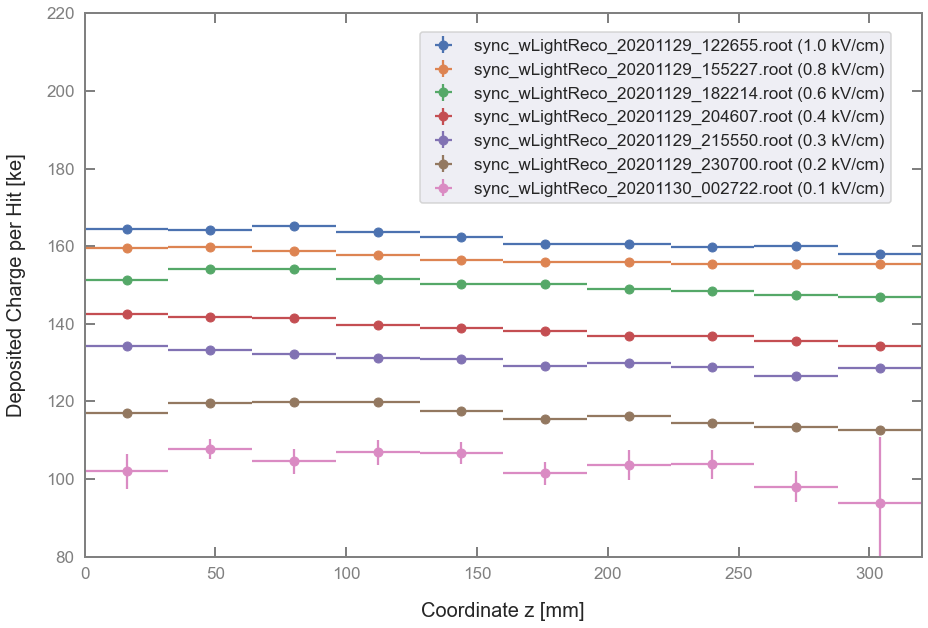

In [14]:
# Plot deposited charge per hit for several data files
seaborn.set(rc={'figure.figsize':(15, 10),})
seaborn.set_context('talk') # or paper

# Define parameters of the frame
fig = plt.figure() # plt.figure(figsize=(width,height))
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.0)
ax.spines['bottom'].set_color('0.5') #'black', ...
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_color('0.5')
ax.spines['top'].set_linewidth(2)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_color('0.5')
ax.spines['right'].set_linewidth(2)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_color('0.5')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_visible(True)

# Ticks, grid and ticks labels
ax.tick_params(direction='in', length=10, width=2,                 # direction, length and width of the ticks (in, out, inout)
               colors='0.5',                                       # color of the ticks ('black', '0.5')
               bottom=True, top=True, right=True, left=True,       # whether to draw the respective ticks
               zorder = 10.,                                       # tick and label zorder
               pad = 10.,                                          # distance between ticks and tick labels
               labelsize = 17,                                     # size of the tick labels
               labelright=False, labeltop=False)                   # wether to draw the tick labels on axes

# Axis limits
ax.set_xlim((x_min,x_max))
ax.set_ylim((80,220))
#ax.set_ylim((y_min,y_max))

for chain in range(len(input_tree_list)):
    
    # Make file selection
    if chain not in [1,6,10,14,16,18,20]:
        continue
    
    label = str(files[chain])+' ('+str(eField_intensity_list[chain])+' kV/cm)'
    plt.errorbar(pos_z_list[chain], mean_q_list[chain], xerr=x_err_list[chain], yerr=sem_q_list[chain], fmt='o', label=label) # fmt='-o'

# Legend
plt.legend(loc=[0.4,0.65], prop={'size': 17}) # loc='upper right'

# Axis labels
axis_labels = ['Coordinate z [mm]','Deposited Charge per Hit [ke]']
plt.xlabel(axis_labels[0], fontsize=20, labelpad=20)
plt.ylabel(axis_labels[1], fontsize=20, labelpad=20)

# Logarithmic y axis
#plt.ylim(bottom=0.9) #, top=200)
#plt.yscale('linear') # linear, log

# Save figure
save_name = 'plots/TGraphError_qPerHit_vs_z_summary.png'
plt.savefig(save_name, dpi=400) # bbox_inches='tight'
#plt.close()

In [15]:
# Plot profile plot of all_hits_q vs all_hits_z AND
# Plot electron lifetime
eLifeTimes     = []
eLifeTimes_err = []

# Create eLifetimes file
f = open('eLifetimes.txt','w')
f.write('filename-string,eLifetime[us],uncertainty[us]')
f.close()

out = display(progress(0,len(input_tree_list),'files processed'),display_id=True)
for chain in range(len(input_tree_list)):
    
    # First plot:
    # Plot profile plot of all_hits_q_list[chain] vs all_hits_z_list[chain]
    x_min    = 0
    x_max    = 320 #max(pixels_z_max,np.max(all_hits_z_list[chain]))
    n_bins_x = 10
    x_width  = (x_max-x_min)/n_bins_x
    x_bin_middle    = []
    mean_q_in_bin_i = []
    std_q_in_bin_i  = []
    sem_q_in_bin_i  = []
    for x_bin in range(n_bins_x):
        x_bin_middle.append((x_bin+0.5)*x_width)
        _q_list = []
        for hit in range(len(all_hits_z_list[chain])):        
            if all_hits_z_list[chain][hit]>x_bin*x_width and all_hits_z_list[chain][hit]<(x_bin+1)*x_width:
                _q_list.append(all_hits_q_list[chain][hit])
        mean_q_in_bin_i.append(np.nanmean(_q_list))
        std_q_in_bin_i.append(np.nanstd(_q_list))
        sem_q_in_bin_i.append(scipy.stats.sem(_q_list))
    x_err    = [0.5*x_width for i in range(n_bins_x)]
    y_err    = [0.5*x_width for i in range(n_bins_x)]
    y_min    = 80 #0.5*np.max(all_hits_q)
    y_max    = 200 #1.5*np.max(all_hits_q)
    axis_labels = ['Coordinate z [mm]','Total deposited Charge per hit [ke]']
    save_name = 'plots/profile2D_q_vs_z_'+str(files[chain][16:-5])+'.png'
    plot_profile_of_2D_hist(x_bin_middle,mean_q_in_bin_i,x_err,sem_q_in_bin_i,axis_labels,x_min,x_max,y_min,y_max,save_name)
    #print(' plot saved as', save_name)
    
    #print('x_bin_middle:    ', x_bin_middle)
    #print('mean_q_in_bin_i: ', mean_q_in_bin_i)
    #print('x_err:           ', x_err)
    #print('sem_q_in_bin_i:  ', sem_q_in_bin_i)
    # ------------------------------------------
    #print('pos_z_list:  ', pos_z_list[chain])
    #print('mean_q_list: ', mean_q_list[chain])
    #print('x_err_list:  ', x_err_list[chain])
    #print('sem_q_list:  ', sem_q_list[chain])
    
    # Second plot:
    # Plot electron lifetimes and exponential fit
    # Delete values if there is nan
    x_bin_middle_sel    = []
    x_err_sel           = []
    mean_q_in_bin_i_sel = []
    std_q_in_bin_i_sel  = []
    sem_q_in_bin_i_sel  = []
    for meas in range(len(x_bin_middle)):
        if not (np.isnan(x_bin_middle[meas]) or np.isnan(mean_q_in_bin_i[meas]) or np.isnan(std_q_in_bin_i[meas])):
            x_bin_middle_sel.append(x_bin_middle[meas])
            x_err_sel.append(x_err[meas])
            mean_q_in_bin_i_sel.append(mean_q_in_bin_i[meas])
            std_q_in_bin_i_sel.append(std_q_in_bin_i[meas])
            sem_q_in_bin_i_sel.append(sem_q_in_bin_i[meas])

    ''' Plot as a function of drift distance
    # Note: There might be something wrong when extracting the lifetime (and its uncertainty)
    if len(mean_q_in_bin_i_sel)>0:
        x_min = 0.
        x_max = 320 #x_bin_middle_sel[-1]+x_err_sel[-1]
        y_min = 80 #0.5*np.max(mean_q_in_bin_i_sel)
        y_max = 200 #1.5*np.max(mean_q_in_bin_i_sel)
        axis_labels = ['Coordinate z [mm]','Total deposited Charge per hit [ke]']
        save_name = 'plots/eLifetime_mm_'+str(files[chain][16:-5])+'.png'
        lifetime, lifetime_uncertainty = plot_eLifetime(x_bin_middle_sel,mean_q_in_bin_i_sel,\
                       x_err_sel,sem_q_in_bin_i_sel,\
                       eDrift_vel[chain],\
                       axis_labels,\
                       x_min,x_max,y_min,y_max,\
                       save_name,\
                       'mm')
        
        # Write lifetimes to file
        #with open('eLifetimes.txt','a') as f:
        #    f.write('\n'+str(files[chain][16:-5])+','+str(lifetime_us)+','+str(lifetime_us_uncertainty))
        
        # Do not consider unmeaningful data
        #if lifetime>0. and lifetime<1000000 and lifetime_uncertainty>0. and lifetime_uncertainty<1000000:
        #    eLifeTimes.append(lifetime)
        #    eLifeTimes_err.append(lifetime_uncertainty)
        #else:
        #    eLifeTimes.append(-999.9)
        #    eLifeTimes_err.append(-999.9)
    else:
        continue
    '''
    
    #''' Plot as a function of drift time
    if len(mean_q_in_bin_i_sel)>0:
        drift_binning = np.array(x_bin_middle_sel)/eDrift_vel[chain]
        drift_binning_err = np.array(x_err_sel)/eDrift_vel[chain]
        #print(' drift_binning:     ', drift_binning)
        #print(' drift_binning_err: ', drift_binning_err)
        
        x_min = 0.
        x_max = drift_binning[-1]+drift_binning_err[-1] #320 #x_bin_middle_sel[-1]+x_err_sel[-1]
        y_min = 80 #0.5*np.max(mean_q_in_bin_i_sel)
        y_max = 200 #1.5*np.max(mean_q_in_bin_i_sel)
        axis_labels = ['Drift time [us]','Total deposited Charge per hit [ke]']
        save_name = 'plots/eLifetime_us_'+str(files[chain][16:-5])+'.png'
        
        lifetime, lifetime_uncertainty = plot_eLifetime(drift_binning,mean_q_in_bin_i_sel,\
                       drift_binning_err,sem_q_in_bin_i_sel,\
                       eDrift_vel[chain],\
                       axis_labels,\
                       x_min,x_max,y_min,y_max,\
                       save_name,\
                       'us')
        
        # Write lifetimes to file
        with open('eLifetimes.txt','a') as f:
            f.write('\n'+str(files[chain][16:-5])+','+str(lifetime)+','+str(lifetime_uncertainty))
        
        # Do not consider unmeaningful data
        if lifetime>0. and lifetime<1000000 and lifetime_uncertainty>0. and lifetime_uncertainty<1000000:
            eLifeTimes.append(lifetime)
            eLifeTimes_err.append(lifetime_uncertainty)
        else:
            eLifeTimes.append(-999.9)
            eLifeTimes_err.append(-999.9)
    else:
        continue
    #'''
    
    out.update(progress(chain,len(input_tree_list),'files processed'))
out.update(progress(len(input_tree_list),len(input_tree_list),'files processed'))
print('Done.')

<ipython-input-15-00cc1272d2ee>:30: RuntimeWarning: Mean of empty slice
  mean_q_in_bin_i.append(np.nanmean(_q_list))


Done.


In [16]:
# Plot electron lifetime summary
x_min = -0.5
x_max = len(eLifeTimes)
y_min = 0
y_max = 14
axis_labels = ['Run File [-]','Electron Lifetime [ms]']
save_name = 'plots/eLifeTimes_summary.png'

x_vals = []
x_errs = []
for i in range(len(eLifeTimes)):
    x_vals.append(i)
    x_errs.append(0.25)
plot_errorbars(x_vals,0.001*np.array(eLifeTimes),x_errs,0.001*np.array(eLifeTimes_err),x_min,x_max,y_min,y_max,axis_labels,save_name)
print('Done.')

Done.


In [17]:
# Plot eventDisplays of rejected_trackIDs_list
# Loop over all chains (= input files)
for chain in range(len(input_tree_list)):
    if chain>0:
        break
    
    # Only proceed if track_id was rejected
    out = display(progress(0,len(rejected_trackIDs_list[chain]),'tracks processed'),display_id=True)
    for track_id in range(input_tree_list[chain].GetEntries()):
        input_tree_list[chain].GetEntry(track_id)
        
        if track_id>=0:
            break
        
        out.update(progress(track_id,len(rejected_trackIDs_list[chain]),'tracks processed'))
        if track_id not in rejected_trackIDs_list[chain]:
            continue
        
        print(' ----------------------------- ')
        print(' track_id: ', track_id)
        print(' start z:  ', input_tree_list[chain].t_track_start_pos_z)
        print(' end z:    ', input_tree_list[chain].t_track_end_pos_z)
        
        # Loop over all hits of rejected track_id
        hits_x = []
        hits_y = []
        hits_z = []
        hits_q = []
        for hit in range(input_tree_list[chain].t_track_nhits):
            hit_x =     input_tree_list[chain].t_track_hits_x[hit]
            hit_y =     input_tree_list[chain].t_track_hits_y[hit]
            hit_z = 0.1*input_tree_list[chain].t_track_hits_z[hit] # TODO: factor 0.1 due to factor 10 problem -> fix it
            hit_q = input_tree_list[chain].t_track_hits_q[hit]
            hits_x.append(hit_x)
            hits_y.append(hit_y)
            hits_z.append(hit_z)
            hits_q.append(hit_q)
            #all_hits_x.append(hit_x)
            #all_hits_y.append(hit_y)
            #all_hits_z.append(hit_z)
            #all_hits_q.append(hit_q)
        input_lists = [hits_x,hits_y,hits_z,hits_q]
        
        
        # Plot 3D
        x_min    = pixels_x_min
        x_max    = pixels_x_max
        y_min    = pixels_y_min
        y_max    = pixels_y_max
        z_min    = 0
        z_max    = 320 #max(pixels_z_max,np.max(all_hits_z_list[chain]))
        n_bins_x = n_pixels_x
        n_bins_y = n_pixels_y
        n_bins_z = n_pixels_z
        x_bins = np.linspace(x_min,x_max,n_bins_x)
        y_bins = np.linspace(y_min,y_max,n_bins_y)
        z_bins = np.linspace(z_min,z_max,n_bins_z)
        save_name = 'plots/h3_rejected_trackID_'+str(track_id)+'_'+str(files[chain][16:-5])+'.png'
        print(save_name)
        axis_labels = ['Coordinate x [mm]','Coordinate y [mm]','Coordinate z [mm]','Charge Deposition [ke]']
        plot_event_3D(input_lists,x_bins,y_bins,z_bins,axis_labels,save_name)
        
        # Plot 1D
        save_name = 'plots/h3_rejected_trackID_'+str(track_id)+'_z'+str(files[chain][16:-5])+'.png'
        plot_h1(hits_z,0,500,100,['Coordinate z [mm]','Entries [-]'],save_name)
        
out.update(progress(len(rejected_trackIDs_list[chain]),len(rejected_trackIDs_list[chain]),'tracks processed'))
print('Done.')

Done.
